# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
import os
import time
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Useful

In [3]:
def check_shape_head(df : pd.DataFrame):
    assert isinstance(df, pd.DataFrame), f"{df} sould be a pandas dataframe"
    print(df.shape)
    return df.head(2)

# Retrieve data

In [4]:
# take environment variables from .env.
# load_dotenv()

data_path = os.getenv("DATA_HR")

#Retrieve dataset from local directory
dataset = pd.read_csv(data_path)

pd.set_option('display.max_columns', None)
check_shape_head(dataset)

(14999, 62)


ID    Name  Department GEO             Role  Rising_Star  Will_Relocate  \
0   1  BRADDY  Operations  US               VP          NaN              0   
1   2   BORST       Sales  UK  Senior Director          NaN              0   

   Critical  Trending Perf  Talent_Level  Validated_Talent_Level  \
0       1.0              3             6                       6   
1       NaN              3             6                       6   

   Percent_Remote  EMP_Sat_OnPrem_1  EMP_Sat_OnPrem_2  EMP_Sat_OnPrem_3  \
0             0.4               3.0               3.0               4.0   
1             0.4               3.0               3.0               4.0   

   EMP_Sat_OnPrem_4  EMP_Sat_OnPrem_5  EMP_Sat_Remote_1  EMP_Sat_Remote_2  \
0               3.0               5.0                 2                 3   
1               3.0               5.0                 2                 3   

   EMP_Sat_Remote_3  EMP_Sat_Remote_4  EMP_Sat_Remote_5  EMP_Engagement_1  \
0                 2                 3                 2                 5   
1                 2                 3                 2                 5   

   EMP_Engagement_2  EMP_Engagement_3  EMP_Engagement_4  EMP_Engagement_5  \
0                 5                 4                 4                 3   
1                 5                 4                 4                 3   

   last_evaluation  number_project  average_montly_hours  time_spend_company  \
0             0.36               3                   168                   3   
1             0.36               5                   159                   2   

   Work_accident  left_Company  CSR Factor  promotion_last_5years       sales  \
0              1             0         NaN                      0       sales   
1              0             0         NaN                      0  accounting   

  salary Gender  LinkedIn_Hits  Emp_Work_Status2  Emp_Work_Status_3  \
0    low      M              5                 4                  3   
1    low      F             58                 3                  3   

   Emp_Work_Status_4  Emp_Work_Status_5  Emp_Identity  Emp_Role  Emp_Position  \
0                  1                  1             1         1             2   
1                  4                  3             2         1             2   

   Emp_Title  Women_Leave  Men_Leave  Emp_Competitive_1  Emp_Competitive_2  \
0          1          NaN        1.0                  2                  4   
1          1          0.0        NaN                  2                  2   

   Emp_Competitive_3  Emp_Competitive_4  Emp_Competitive_5  \
0                  2                  2                  2   
1                  1                  4                  1   

   Emp_Collaborative_1  Emp_Collaborative_2  Emp_Collaborative_3  \
0                    2                    2                    2   
1                    3                    2                    5   

   Emp_Collaborative_4  Emp_Collaborative_5  Sensor_StepCount  \
0                    1                    5              1841   
1                    1                    5              1990   

   Sensor_Heartbeat(Average/Min)  Sensor_Proximity(1-highest/10-lowest)  
0                             61                                      9  
1                             90                                      8

# Data preparation

In [5]:
# Remove unwanted columns
dropped_columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales']

dataset.drop(columns = dropped_columns, inplace = True)

In [6]:
# Rename columns
dataset = dataset.rename(columns={
                                    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
                                    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
                                })
# check_shape_head(dataset)

In [7]:
# Convert column names to lower snake case
dataset.columns = dataset.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')
# check_shape_head(dataset)

# General prerequisities

In [8]:
# checking missing values
dataset.isnull().sum().sort_values(ascending=False);

# impute binary missing values for critical column
dataset.loc[dataset['critical'].isna(), 'critical'] = 0

# covert gender column into binary classification column
dataset['gender'] = dataset['gender'].map({'F': 1, 'M': 0})

# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']
imputer = SimpleImputer(strategy='most_frequent')
dataset[columns_to_impute] = imputer.fit_transform(dataset[columns_to_impute])

# target imbalancing
# the target is imbalanced, however we aim to predict those consumers who will be retained within the company,
# and this is 76% of the data, so we rebalancing is necessary.

dataset['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

# Numerical Features Data Cleaning ONLY

/tmp/ipykernel_8708/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_8708/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_8708/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset[column], palette='Set2')
/tmp/ipykernel_8708/3659021935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legen

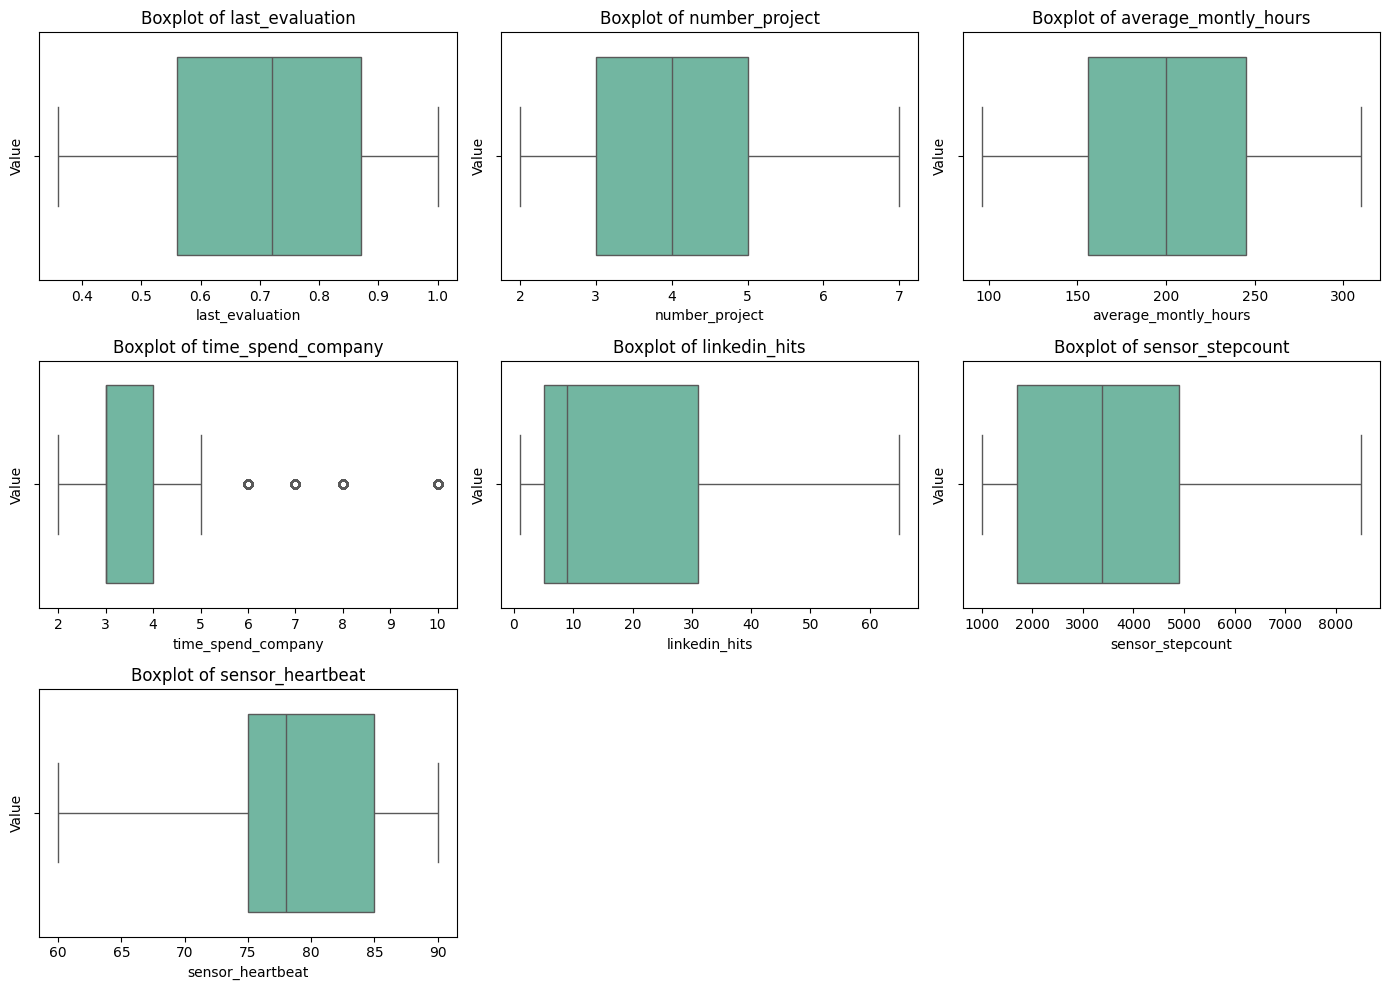

In [9]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=dataset[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [10]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.
rb_scaler = RobustScaler()
dataset['time_spend_company'] = rb_scaler.fit_transform(dataset[['time_spend_company']])

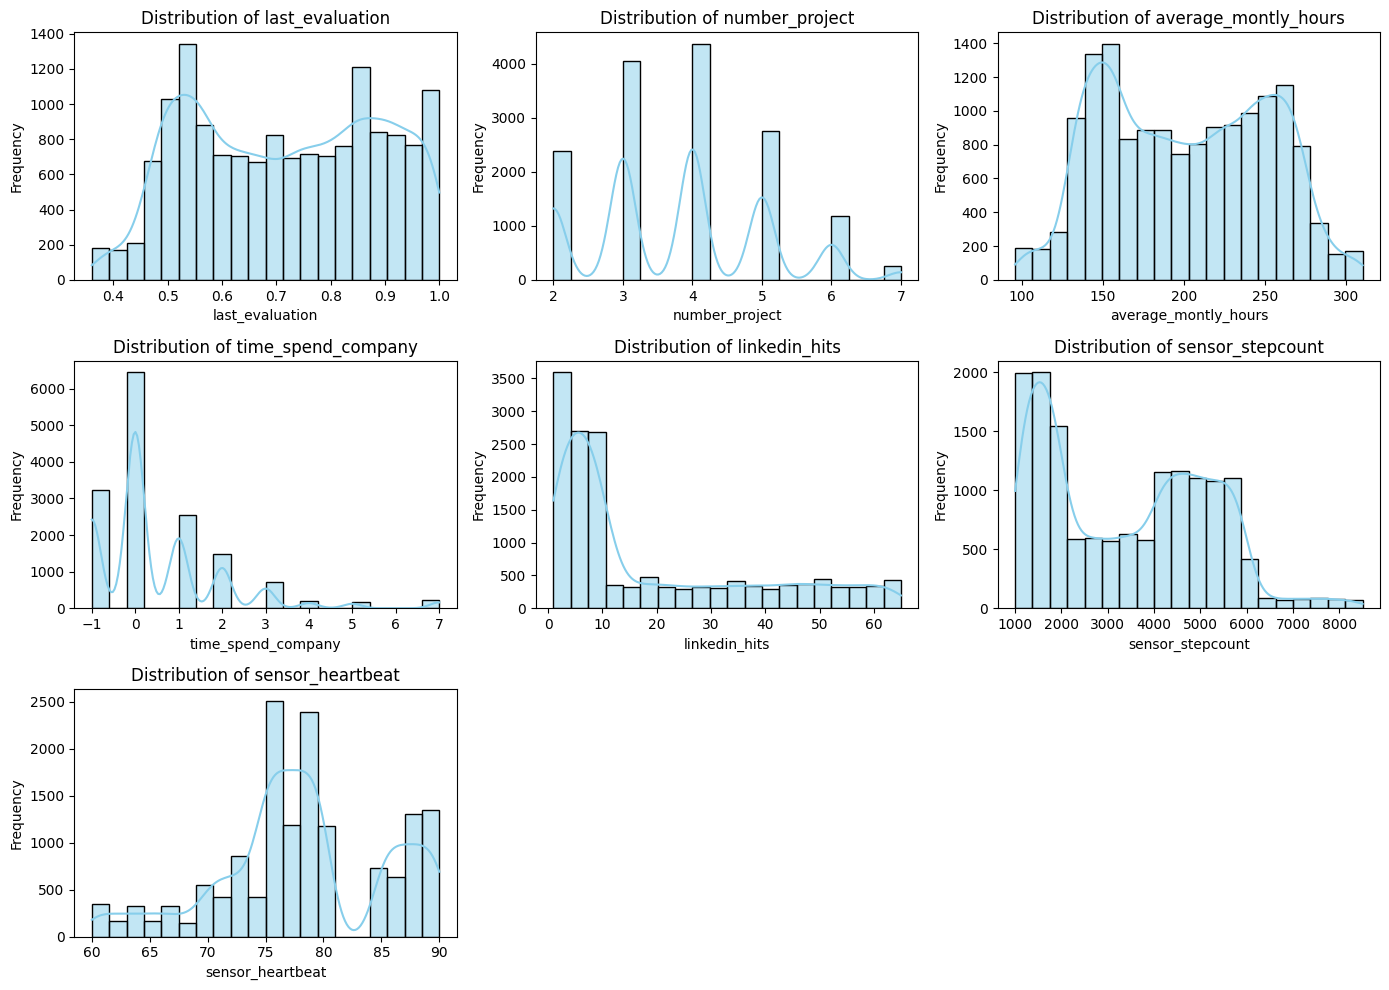

In [11]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
# for all other numerical variables, use the minmaxscaler
minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
dataset[minmaxscaler_columns] = scaler.fit_transform(dataset[minmaxscaler_columns])

# Categorical Features ONLY Feature Engineering

In [13]:
# ordinal encoding for salary
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(dataset[['salary']])
print(ordinal_encoder.categories_)
dataset['encoded_salary'] = ordinal_encoder.transform(dataset[['salary']]) # 1 = low, 2 = medium, 3 = high
dataset.drop(columns = ['salary'], inplace = True)

[array(['high', 'low', 'medium'], dtype=object)]


In [14]:
# OneHotEncoding for department, geo and role
ohe_columns = ['department', 'geo', 'role']
ohe = OneHotEncoder(sparse_output = False)
ohe_data = ohe.fit_transform(dataset[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))
encoded_dataset = pd.concat([dataset, ohe_df], axis=1)
encoded_dataset.drop(columns = ['department', 'geo', 'role'], inplace = True)

In [15]:
check_shape_head(encoded_dataset)

(14999, 63)


will_relocate  critical  percent_remote  emp_sat_onprem_4  \
0              0       1.0             0.4               3.0   
1              0       0.0             0.4               3.0   

   emp_sat_onprem_5  emp_sat_remote_1  emp_sat_remote_2  emp_engagement_1  \
0               5.0                 2                 3                 5   
1               5.0                 2                 3                 5   

   last_evaluation  number_project  average_montly_hours  time_spend_company  \
0              0.0             0.2              0.336449                 0.0   
1              0.0             0.6              0.294393                -1.0   

   work_accident  left_company  promotion_last_5years  gender  linkedin_hits  \
0              1             0                      0       0       0.062500   
1              0             0                      0       1       0.890625   

   emp_work_status2  emp_work_status_3  emp_work_status_4  emp_work_status_5  \
0                 4                  3                  1                  1   
1                 3                  3                  4                  3   

   emp_identity  emp_role  emp_position  emp_title  women_leave  men_leave  \
0             1         1             2          1          NaN        1.0   
1             2         1             2          1          0.0        NaN   

   emp_competitive_1  emp_competitive_2  emp_competitive_3  emp_competitive_4  \
0                  2                  4                  2                  2   
1                  2                  2                  1                  4   

   emp_competitive_5  emp_collaborative_1  emp_collaborative_2  \
0                  2                    2                    2   
1                  1                    3                    2   

   emp_collaborative_3  emp_collaborative_4  emp_collaborative_5  \
0                    2                    1                    5   
1                    5                    1                    5   

   sensor_stepcount  sensor_heartbeat  sensor_proximity  encoded_salary  \
0          0.112133          0.033333                 9             1.0   
1          0.132000          1.000000                 8             1.0   

   department_Finance  department_Human Resources  department_IT  \
0                 0.0                         0.0            0.0   
1                 0.0                         0.0            0.0   

   department_Operations  department_Sales  department_Warehouse  \
0                    1.0               0.0                   0.0   
1                    0.0               1.0                   0.0   

   geo_Australia  geo_China  geo_Colombia  geo_France  geo_Japan  geo_Korea  \
0            0.0        0.0           0.0         0.0        0.0        0.0   
1            0.0        0.0           0.0         0.0        0.0        0.0   

   geo_Turkey  geo_UK  geo_US  role_Director  role_Level 1  role_Level 2-4  \
0         0.0     0.0     1.0            0.0           0.0             0.0   
1         0.0     1.0     0.0            0.0           0.0             0.0   

   role_Manager  role_Senior Director  role_Senior Manager  role_VP  
0           0.0                   0.0                  0.0      1.0  
1           0.0                   1.0                  0.0      0.0

# Assumption : drop Women_Leave and Men_Leave columns

In [16]:
# Need to decide together.
encoded_dataset.drop(columns = ['women_leave', 'men_leave'], inplace = True)

In [17]:
# Updating dropped columns
for col in ['women_leave', 'men_leave']:
    dropped_columns.append(col)
    
dropped_columns;

# Feature correlation

<Axes: >

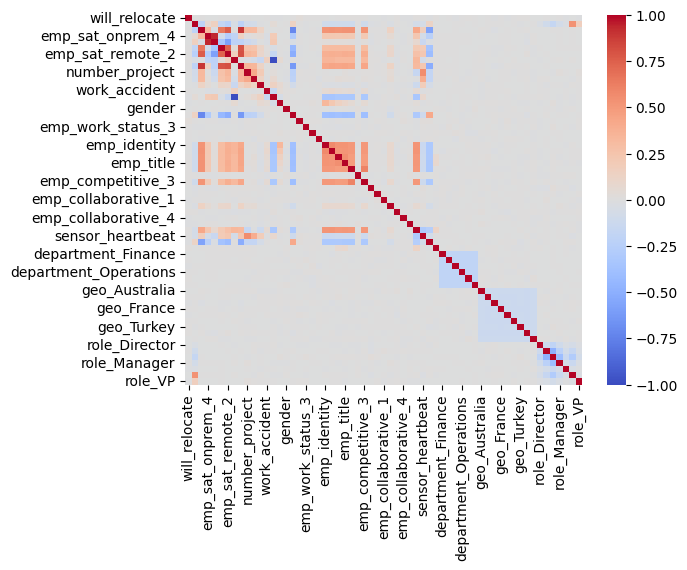

In [18]:
#Compute feature correlation
sns.heatmap(encoded_dataset.corr(), cmap='coolwarm')

In [19]:
# Calculate the correlation matrix
corr_matrix = encoded_dataset.corr()

In [20]:
# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

In [21]:
# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 
corr_df

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

# Select highly correlated features >= 0.7 or <= -0.7
correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]
correlated_features

feature_1         feature_2  correlation
177  emp_sat_onprem_5  emp_sat_onprem_4     0.930062
124   last_evaluation    percent_remote     0.897223
346   last_evaluation  emp_sat_remote_2     0.805922
292   last_evaluation  emp_sat_remote_1     0.796292
122  emp_sat_remote_2    percent_remote     0.762327
290  emp_sat_remote_2  emp_sat_remote_1     0.735748
132     linkedin_hits    percent_remote    -0.713644
404      left_company  emp_engagement_1    -1.000000

In [23]:
# remove highly correlated features >= 0.7 or <= -0.7
encoded_dataset.drop(columns=['emp_sat_onprem_4','percent_remote',
                'emp_sat_remote_2','emp_sat_remote_1',
                'emp_engagement_1'], inplace = True)

In [25]:
# Updating dropped columns
for col in ['emp_sat_onprem_4','percent_remote',
                'emp_sat_remote_2','emp_sat_remote_1',
                'emp_engagement_1']:
    dropped_columns.append(col)

# List of dropped columns

In [26]:
dropped_columns;

# Define X (features)

In [27]:
#Features
X = encoded_dataset.drop(columns=['left_company'])
check_shape_head(X)

(14999, 55)


will_relocate  critical  emp_sat_onprem_5  last_evaluation  number_project  \
0              0       1.0               5.0              0.0             0.2   
1              0       0.0               5.0              0.0             0.6   

   average_montly_hours  time_spend_company  work_accident  \
0              0.336449                 0.0              1   
1              0.294393                -1.0              0   

   promotion_last_5years  gender  linkedin_hits  emp_work_status2  \
0                      0       0       0.062500                 4   
1                      0       1       0.890625                 3   

   emp_work_status_3  emp_work_status_4  emp_work_status_5  emp_identity  \
0                  3                  1                  1             1   
1                  3                  4                  3             2   

   emp_role  emp_position  emp_title  emp_competitive_1  emp_competitive_2  \
0         1             2          1                  2                  4   
1         1             2          1                  2                  2   

   emp_competitive_3  emp_competitive_4  emp_competitive_5  \
0                  2                  2                  2   
1                  1                  4                  1   

   emp_collaborative_1  emp_collaborative_2  emp_collaborative_3  \
0                    2                    2                    2   
1                    3                    2                    5   

   emp_collaborative_4  emp_collaborative_5  sensor_stepcount  \
0                    1                    5          0.112133   
1                    1                    5          0.132000   

   sensor_heartbeat  sensor_proximity  encoded_salary  department_Finance  \
0          0.033333                 9             1.0                 0.0   
1          1.000000                 8             1.0                 0.0   

   department_Human Resources  department_IT  department_Operations  \
0                         0.0            0.0                    1.0   
1                         0.0            0.0                    0.0   

   department_Sales  department_Warehouse  geo_Australia  geo_China  \
0               0.0                   0.0            0.0        0.0   
1               1.0                   0.0            0.0        0.0   

   geo_Colombia  geo_France  geo_Japan  geo_Korea  geo_Turkey  geo_UK  geo_US  \
0           0.0         0.0        0.0        0.0         0.0     0.0     1.0   
1           0.0         0.0        0.0        0.0         0.0     1.0     0.0   

   role_Director  role_Level 1  role_Level 2-4  role_Manager  \
0            0.0           0.0             0.0           0.0   
1            0.0           0.0             0.0           0.0   

   role_Senior Director  role_Senior Manager  role_VP  
0                   0.0                  0.0      1.0  
1                   1.0                  0.0      0.0

# Define y (target)

In [28]:
#Target
y = encoded_dataset['left_company']

# Learning curves

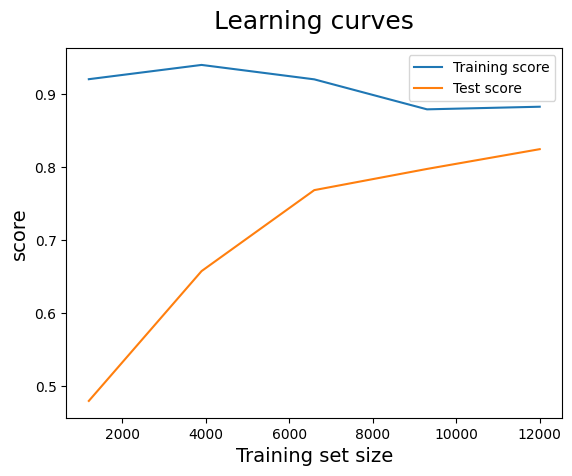

In [29]:
import numpy as np
from sklearn.model_selection import learning_curve

# train_sizes = [25,50,75,100,250,500,750,1000,1150]
train_sizes = np.linspace(0.1, 1.0, 5)

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000), X=X, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

# Train test split

In [30]:
# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=10)

In [31]:
#Check shapes
print(f"X_train shape is : {X_train.shape}")
print(f"y_train shape is : {y_train.shape}\n")
print(f"X_test shape is : {X_test.shape}")
print(f"y_test shape is : {y_test.shape}")

X_train shape is : (10499, 55)
y_train shape is : (10499,)

X_test shape is : (4500, 55)
y_test shape is : (4500,)


# Logistic regression

In [32]:
# Instanciate the logistic regression model
log_reg_mdl = LogisticRegression(max_iter=500, class_weight='balanced')

#Fitting the model to train set (features and target)
log_reg_mdl.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

In [33]:
#Evaluation

y_pred = log_reg_mdl.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8375555555555556

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      3449
           1       0.61      0.87      0.71      1051

    accuracy                           0.84      4500
   macro avg       0.78      0.85      0.80      4500
weighted avg       0.87      0.84      0.85      4500

